In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'plot_hist_read_count',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
dfs = list()

for i in snakemake.input['hist']:
    library_prep, platform = Path(i).stem.split('_')[:2]
    df = pd.read_csv(i).set_index('index')
    df['data source'] = f'{library_prep} {platform}'
    dfs.append(df)

df = pd.concat(dfs).rename(columns={'dist': 'Distance to annotated TES'})

In [4]:
df['data source'] = df['data source'].replace('quantseq Illumina', 'Quantseq3')

In [5]:
df = df[df['Distance to annotated TES'].abs() < 25]

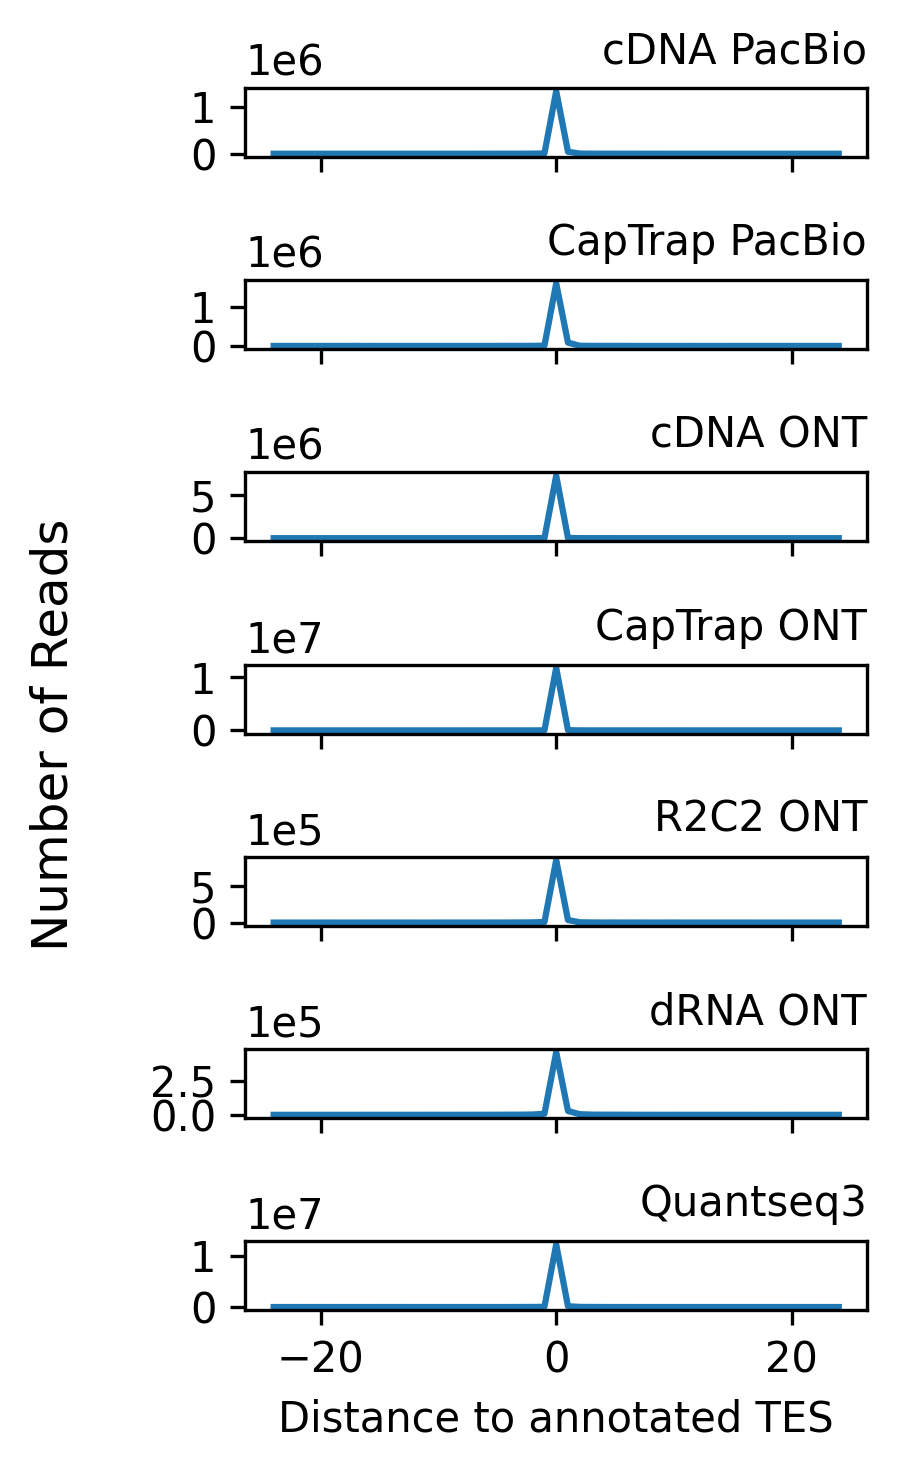

In [6]:
data_sources = df['data source'].unique()

fig, axs = plt.subplots(len(data_sources), figsize=(3, 5), dpi=300, sharex=True)
fig.tight_layout()

for i, data_source in enumerate(data_sources):
    axs[i].set_title(data_source.replace(' \n', ''), loc='right', fontsize=10)
    sns.lineplot(x='Distance to annotated TES', y='Value', 
                 data=df[df['data source'] == data_source], 
                 ax=axs[i])
    axs[i].set_ylabel('')

    axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))


plt.subplots_adjust()
fig.supylabel('Number of Reads')
plt.tight_layout()

plt.savefig(snakemake.output['hist'], bbox_inches = "tight")

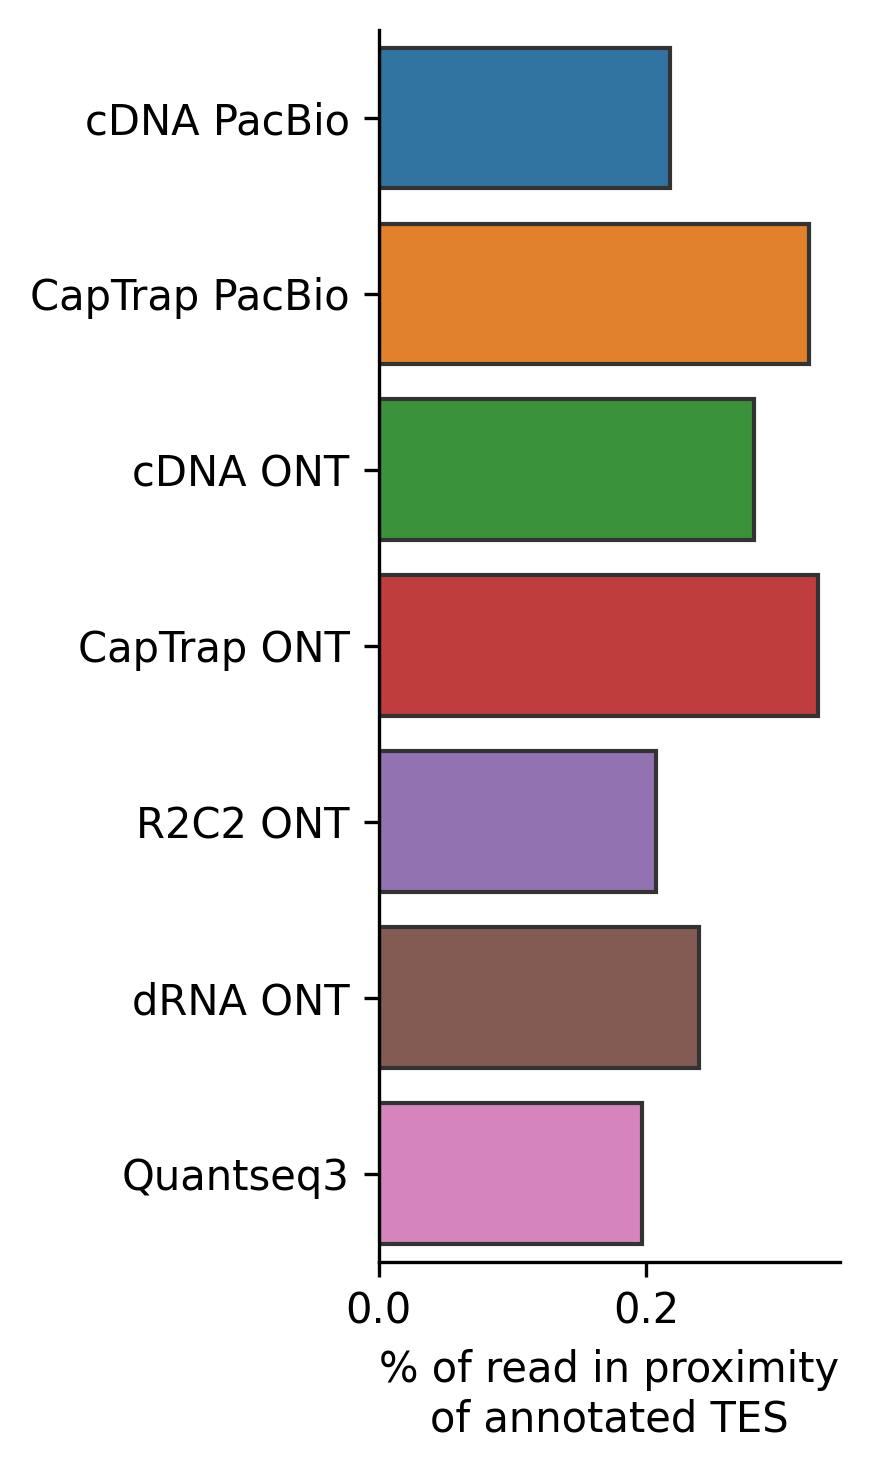

In [7]:
plt.figure(figsize=(3, 5), dpi=300)

rows = list()

for i in snakemake.input['percentage']:
    library_prep, platform = Path(i).stem.split('_')[:2]
    with open(i) as f:
        rows.append({'data source': f'{library_prep} {platform}', 
                     'percentage': float(f.readline())})
        
ylabel = '% of read in proximity\nof annotated TES'
df = pd.DataFrame(rows).rename(columns={'percentage': ylabel})
df['data source'] = df['data source'].replace('quantseq Illumina', 'Quantseq3')

sns.barplot(data=df, y="data source", x=ylabel, linewidth=1, edgecolor=".2")
plt.ylabel('')

sns.despine();

plt.tight_layout()
plt.savefig(snakemake.output['percent'], bbox_inches = "tight")